####목표
* 개인적으로 어려웠던 코드가 많은 섹션으로
  100%의 정확도를 가진 분류기를 만들어보고 싶었음 (데이터 : 포켓몬이미지) 

* 

####현재 상황
* 이미지 전처리, 다양한 파라미터 설정하여 모델 구축.

####미비된 부분
* 훈련대비 검증 정확도가 너무낮음 -> 과적합
* 이후 전이학습 등을 사용하여 정리해야할 것 같음


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
####os 모듈
> 운영체제를 제어할 수 있다.(Operating System)


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
#pokemonData 데이터가 들어있는 파일(디렉토리) 
directory = '/content/drive/MyDrive/project/PokemonData'

#os.listdir() : 지정한 디렉토리 안에있는 모든 디렉토리에 대하여 디렉토리의 이름을 리스트를 반환
labels = os.listdir(directory)

#디렉토리 리스트의 총 개수
nb = len(labels)

#리스트 출력
print(labels)

#포맷팅을 통한 출력
print(f'라벨의 개수는 총 {nb}입니다')

['Abra', 'Alolan Sandslash', 'Blastoise', 'Aerodactyl', 'Beedrill', 'Bellsprout', 'Arbok', 'Articuno', 'Alakazam', 'Arcanine', 'Caterpie', 'Charmander', 'Bulbasaur', 'Clefairy', 'Charmeleon', 'Chansey', 'Charizard', 'Cloyster', 'Butterfree', 'Clefable', 'Dodrio', 'Doduo', 'Cubone', 'Dragonair', 'Dragonite', 'Dewgong', 'Diglett', 'Ditto', 'Drowzee', 'Dratini', 'Dugtrio', 'Eevee', 'Farfetchd', 'Exeggutor', 'Flareon', 'Fearow', 'Electrode', 'Ekans', 'Exeggcute', 'Electabuzz', 'Gengar', 'Grimer', 'Geodude', 'Gastly', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Graveler', 'Golem', 'Horsea', 'Jigglypuff', 'Growlithe', 'Hitmonlee', 'Gyarados', 'Haunter', 'Hypno', 'Hitmonchan', 'Jolteon', 'Ivysaur', 'Kakuna', 'Krabby', 'Lapras', 'Kangaskhan', 'Jynx', 'Kadabra', 'Kabuto', 'Kingler', 'Kabutops', 'Koffing', 'Magnemite', 'Magikarp', 'Machamp', 'Marowak', 'Machop', 'Lickitung', 'Magmar', 'Magneton', 'Mankey', 'Machoke', 'Muk', 'Meowth', 'Mewtwo', 'Nidoking', 'Nidoqueen', 'MrMime', 'Moltres', 'Nidorin

#### 🔰 이미지 경로를 데이터 프레임으로 만들어봅니다.



In [ ]:
#파일 시스템 경로를 찾기 위한 라이브러리 불러오기.
from pathlib import Path

directory = Path('/content/drive/MyDrive/project/PokemonData')

#디렉토리 내부의 jpg에 대한 경로를 리스트로 생성.
#.glob()를 사용하여 디렉토리 내부의 경로를 받는다.
# 디렉토리 내부의 모든 jpg 파일에 대한 경로를 받고 싶으므로,
# 재귀적으로 찾을 때 사용하는 '**'을 함께 사용한다. 
filepaths = list(directory.glob(r'**/*.jpg'))



#이미지 경로 및 이미지가 속한 디렉토리의 이름으로 데이터 프레임을 생성하는 함수
def proc_img(filepath):
    """ 사진의 파일 경로와 포켓몬의 이름으로 데이터 프레임을 생성합니다.
    """
    #이미지 경로에서 디렉토리 이름만 따로 출력하여 리스트 생성 
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    
    #이미지 경로를 시리즈 형태로 생성.
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    
    #추출한 디렉토리 이름을 시리즈 형태로 생성한다.
    labels = pd.Series(labels, name='Label')

    # 이미지 경로와 디렉토리이름을 합치기.
    df = pd.concat([filepath, labels], axis=1)

    #생성된 데이터 프레임을 섞고 인덱스 리셋
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df

,Filepath,Label
0,/content/drive/MyDrive/project/PokemonData/Scy...,Scyther
1,/content/drive/MyDrive/project/PokemonData/Dew...,Dewgong
2,/content/drive/MyDrive/project/PokemonData/Ivy...,Ivysaur
3,/content/drive/MyDrive/project/PokemonData/Mew...,Mew
4,/content/drive/MyDrive/project/PokemonData/Vul...,Vulpix
...,...,...
6654,/content/drive/MyDrive/project/PokemonData/San...,Sandshrew
6655,/content/drive/MyDrive/project/PokemonData/Mag...,Magmar
6656,/content/drive/MyDrive/project/PokemonData/Gri...,Grimer
6657,/content/drive/MyDrive/project/PokemonData/Lap...,Lapras


In [ ]:
print(f'이미지 개수: {df.shape[0]}\n')
print(f'고유 포캣몬의 개수 : {len(df.Label.unique())}\n')
print(f'포켓몬의 종류: {df.Label.unique()}')

이미지 개수: 6659

고유 포캣몬의 개수 : 150

포켓몬의 종류: ['Scyther' 'Dewgong' 'Ivysaur' 'Mew' 'Vulpix' 'Mankey' 'Krabby' 'Graveler'
 'Onix' 'Dragonair' 'Alakazam' 'Rapidash' 'Wartortle' 'Jolteon' 'Rhyhorn'
 'Vileplume' 'Victreebel' 'Diglett' 'Magikarp' 'Pidgeot' 'Tauros'
 'Sandslash' 'Hitmonlee' 'Hitmonchan' 'Tentacruel' 'Chansey' 'Parasect'
 'Cubone' 'Magnemite' 'Wigglytuff' 'Grimer' 'Golduck' 'Lickitung' 'Pidgey'
 'Machoke' 'Metapod' 'Charmeleon' 'Porygon' 'Electabuzz' 'Gastly'
 'Clefable' 'Tangela' 'Psyduck' 'Magneton' 'Koffing' 'Bellsprout'
 'Shellder' 'Kabutops' 'Machamp' 'Haunter' 'Seaking' 'Exeggutor' 'Seel'
 'Poliwhirl' 'Poliwag' 'Blastoise' 'Gloom' 'Golem' 'Weezing' 'Omastar'
 'Ninetales' 'Magmar' 'Horsea' 'Kabuto' 'Growlithe' 'Nidoqueen' 'Rattata'
 'Kadabra' 'Starmie' 'Gengar' 'Primeape' 'Omanyte' 'Voltorb' 'Persian'
 'Exeggcute' 'Meowth' 'Slowbro' 'Dugtrio' 'Sandshrew' 'Moltres' 'Clefairy'
 'Charmander' 'Seadra' 'Venomoth' 'Gyarados' 'Lapras' 'Ditto' 'Snorlax'
 'Vaporeon' 'Beedrill' 'Pinsir

###Label category 분포를 확인합니다.
>상위 10개의 차트와 하위 10개의 차트를 나눠 출력합니다.

#### Why?
* 150개의 각기 다른 포켓몬의 이미지 사진을 한 번에 보여주기에는
출력 이미지가 좋지 않음. 

* 상위 & 하위 부분만을 보여주면 나머지 포켓몬 이미지 개수는 이 사이에
 있는 것임을 자연스레 유추 할 수 있음

* 이미지 증강을 쓰기 위해 적절한 상황인지 확인하고 싶었음!

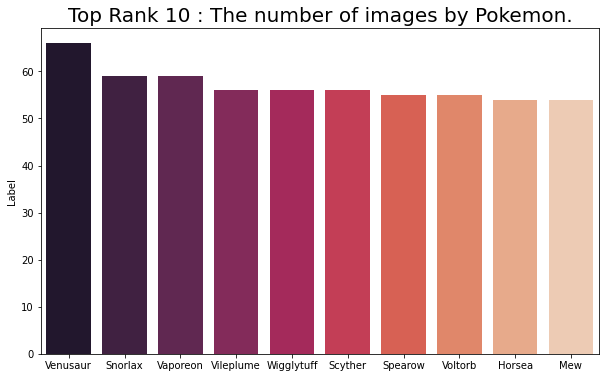

In [ ]:
#사용할 라이브러리를 불러옵니다(plt,sns)
import matplotlib.pyplot as plt
import seaborn as sns


vc = df['Label'].value_counts().head(10)
vc
plt.figure(figsize=(10,6))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Top Rank 10 : The number of images by Pokemon.", fontsize = 20)
plt.show()

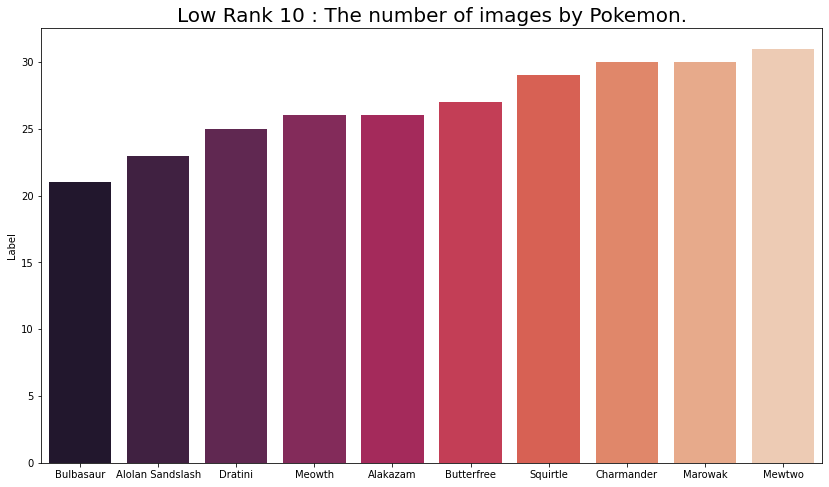

In [ ]:
vc = df['Label'].value_counts(ascending=True).head(10)
vc
plt.figure(figsize=(14,8))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Low Rank 10 : The number of images by Pokemon.", fontsize = 20)
plt.show()

In [ ]:
from tensorflow.keras import Sequential
import keras
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

---
####이미지 데이터들의 가로 세로 크기 확인.

In [ ]:
#폴더에서 원하는 파일 형태만 불러오기.

# 1. 경로
path = '/content/drive/MyDrive/project/PokemonData/Pikachu'

# 2. 해당 폴더로 이동 
#os.chdir(path)

# 3. 해당 폴더안에 있는 파일이름을 리스트 형태로 받음
files = os.listdir(path) 

In [ ]:
files

['00000069.png',
 '6fafbe812e8c4b9ba16d727cc9b6a127.jpg',
 '00000038.png',
 '9a986c5f04f6478c85da7d8b4e79048b.jpg',
 '00000016.jpg',
 '00000040.png',
 '0cdf621bbee34f768b89d6a519f52f1c.jpg',
 '7fb36ffead6745a3b6b6d8f1aaf7a0cc.jpg',
 '00000044.jpg',
 '00000035.png',
 '00000030.jpg',
 '00000043.png',
 '00000002.png',
 '00000055.png',
 '00000001.png',
 '00000004.jpg',
 '00000067.png',
 '1b88de58ecef49a8a33bd46dc6791915.jpg',
 '00000031.png',
 '9cf323423e1a4862a5474ec358daada1.jpg',
 '00000027.jpg',
 '56d49e45fe0246d8a7eeece8b5569f71.jpg',
 '00000074.png',
 '00000021.png',
 '00000015.png',
 '00000050.png',
 '00000072.jpeg',
 '00000011.png',
 '05da808f2caa4bf0a38449d4b172967a.jpg',
 '00000054.jpg',
 '00000000.jpg',
 '00000018.jpg',
 '00000036.png',
 '00000205.jpeg',
 '00000058.png',
 '00000041.jpg',
 '00000020.png',
 '00000059.jpg',
 '39a31e1c0aea475aa37ce3c60d1495f5.jpg',
 '00000029.jpg',
 '00000046.jpg',
 '00000023.png',
 '7b7b1c9164064c8981b2f31f2feb873e.jpg',
 '00000073.jpg',
 '9e315cea

In [ ]:
#이미지 크기 확인

#라이브러리 생성
from PIL import Image


#이미지 열기
image1 = Image.open('/content/drive/MyDrive/project/PokemonData/Pikachu/00000000.jpg')

#이미지 출력
image1         # -> 피카츄 모양 확인

#이미지 사이즈 출력

imag1_size = image1.size
print(imag1_size)

#-----------------------------------
#또 다른 이미지 크기 확인.

image2 = Image.open('/content/drive/MyDrive/project/PokemonData/Pikachu/00000014.png')
imag2_size = image2.size
print(imag2_size)

(796, 796)
(1254, 1254)


---
###이미지 크기 전처리

1. 확인한 이미지의 크기(가로,세로)가 다르다.
2. 두 개만 확인하였으나, 모든 이미지 크기가 다를 것으로 예상되므로 모두 전처리 한다.
3. 함수를 만들어 한번에 크게 처리하자

In [ ]:
#치수가 150 x 150으로 변경하기
#픽셀 값을 정규화하기.
#넘파이 배열로 변환

stored = {}
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    #레이블(개별 포켓몬에 관한 디렉토리)에 관한 반복문 설정
    for label in labels:
        # os.path.join(a,b) 경로 지정 -> 인수에 전달된 2개의 문자열을 결합하여 1개의 경로로 합치기 가능
        #폴더(경로 설정) : 메인 디렉토리(종류별 포켓몬의 데이터를 담고 있는 파일) 안에 존재하는 개별 포켓몬 디렉토리에 관한 경로
        folder = os.path.join(train_dir,label)
        
        #개별 포켓몬 디렉토리 안에 있는 포켓 이미지파일을 리스트화 하여, 반복문을 출력할꺼다.
        for image in os.listdir(folder):
            
#             print(os.path.join(folder,image))
            try:
                #불러올 포켓몬 이미지의 크기를 재설정합니다.
                #load_img('경로/파일이름.jpg', target_size =(가로,세로) -> 이미지 파일을 불러올 수 있습니다.
                #각각의 이미지를 불러와 이미지의 가로 및 세로 크기를 조정합니다.
                img=load_img(os.path.join(folder,image), target_size=(150,150))
                
                #PIL 형식의 이미지를 Numpy 배열로 변환하기 위한 img_to_array() 함수 
                img=img_to_array(img)
                
                #이미지 정규화
                img=img/255.0

                #데이터셋에 추가
                dataset.append((img,count))
            except:
                pass

        print(f'\rCompleted: {label}',end='')
        stored[label] = count
        count+=1
    
    #데이터 섞기.    
    random.shuffle(dataset)
    
    #인자 언패킹 : zip으로 묶인 인자들을 X와 y로 나눠줌 (현재 X는 정규화된 이미지, y는 정규화된 이미지 label)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)

In [ ]:
X, y = input_target_split(directory,labels)

Completed: Vulpix

In [15]:
np.unique(y)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

#### 영상과 해당 실제 레이블을 시각화하기.


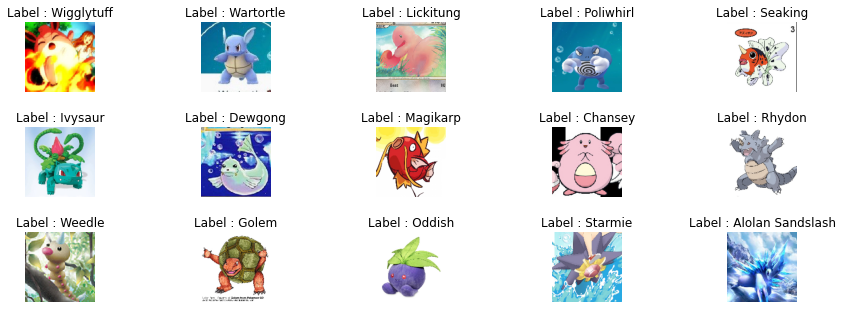

In [16]:
import matplotlib.pyplot as plt
#figure 생성 (생성되는 firgure 크기 확인하기)
plt.figure(figsize = (15,9))
n = 0
for i in range(15):
  n+=1
  #plt.subplot(nrows, ncols, index) 행, 열, 출력되는 Axes의 객체들이 나타날 위치를 의미
  plt.subplot(5, 5, n)
  #레이아웃 너비 및 높이 조정.
  plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
  #출력이미지의 축 제거
  plt.axis('off')
  #이미지 출력
  plt.imshow(X[i])
  # 타이틀명 lables 이용
  plt.title(f'Label : {labels[y[i]]}')



####Image Augmentation : 이미지 증강 ❗
>가지고 있는 데이터가 많지 않은 것을 확인하였다.😒☹<br/>
 추가로 현재 가지고 있는 데이터는 각 포켓몬에 따라 '균일한 이미지 파일'을 가지고 있지 않습니다.<br/>
CNN 모델의 성능을 높이면서 오버피팅을 극복할 수 있는 가장 좋고 근본적인 해결책은 학습데이터의 다양성을 늘리는 것이지만,<br/>
시간과 비용이 많이 소모되는 작업이므로 데이터의 양을 늘리기 위해 **ImageDataGenerator**을 이용합니다. <br/>





In [17]:
#데이터 분할 및 레이블 인코딩
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.22, random_state =42)

In [18]:
print(X_train.shape)

(5321, 150, 150, 3)


In [19]:
#먼저 사용할 라이브러리를 불러옵니다.
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

""" 
   horizontal_flip = 인풋데이터를 무작위로 가로로 뒤집는다. (불리언 형태)
     vertical_flip = 인풋데이터를 무작위로 세로로 뒤집습니다. (불리언 형태)
    rotation_range = 지정된 각도 범위내에서 임의로 원본 이미지를 회전 
        zoom_range = 지정된 확대, 축소 범위내에 임의로 원본이미지를 확대 / 축소 시킨다.
 width_shift_range = 지정된 수평방향 이동 범위내에서 원본 이미지를 이동시킨다.
height_shift_range = 지정된 수직방향 이동 범위 내에서 임의로 원본 이미지를 이동 시킵니다. 수치는 전체 넓이의 비율(실수)로 나타냅니다
       shear_range = 밀린강도 범위내에서 임의로 원본 이미지를 변형 시킵니다. 수치는 시계반대방향으로 밀림강도를 radian으로 나타냅니다. 
         fill_mode = 어떤 모드를 쓰느냐에 따라 다르게 채워지는데, 디폴트값은 nearest이다.
"""
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range =0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range =0.1,
    fill_mode='nearest'
)

testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

In [20]:
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

###신경망 모델 구축.
#### CNN베이스라인 모델 설정.

In [54]:
# Creating a CNN model with 5 layers 64,128,128,128 and 256 filters each with 3x3 kernel size and pooling layers with size 2
# Adding 3 dense layers with 1024,512 neurons with final layer with 150 outputs.
# Batch Normalization and Dropout layers

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dropout(0.25))

model.add(Dense(512,activation='relu'))

model.add(Dense(nb,activation='softmax'))

In [55]:
#summmary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 37, 37, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 37, 37, 64)       

In [56]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics = ['accuracy'])


#categorical_crossentropy **vs** sparse_categorical_crossentropy

* 둘의 차이는 수식의 차이 :y_true의 입력이 다르다.

* sparse의 y_true는 일반 정수가 입력, categorical에서 y_true는 one-hot vector이다.

* ❗logits and labels must have the same first dimension ❗


####Early stopping 사용하기.
> Early stopping을 적용합니다.

In [57]:
# 학습시킨 데이터를 저장시키기 위한 코드입니다. 
checkpoint_filepath = "FMbest.hdf5"

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)



#### 모델 학습하기.
❗ => .fit_generator <br/>
* ImageDataGenerator() 을 사용할 때 쓰는 것 같다.

❗ .fit vs .fit_generator
* 찾아봤는데 뭔가 와닿지 않는다...정리해보자 ㅠㅠ

* 이후 버전에 .fit_generator 이게 없어질거라는걸 얼핏본듯

In [58]:
#실시간 데이터 증강을 사용하여 배치에 대하여 모델배을 학습하기.
#flow : 데이터와 라벨 배열을 받아 증강된 데이터 배치를 생성한다.
#steps_per_epoch : 훈련 샘플 수 / 배치 사이즈 
results = model.fit(X_train, y_train, 
                    epochs = 50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop, save_best])


Epoch 1/50
167/167 [==============================] - ETA: 0s - loss: 5.0108 - accuracy: 0.0070
Epoch 00001: val_loss improved from inf to 5.00946, saving model to FMbest.hdf5
167/167 [==============================] - 160s 957ms/step - loss: 5.0108 - accuracy: 0.0070 - val_loss: 5.0095 - val_accuracy: 0.0153
Epoch 2/50
167/167 [==============================] - ETA: 0s - loss: 4.7751 - accuracy: 0.0180
Epoch 00002: val_loss improved from 5.00946 to 4.57701, saving model to FMbest.hdf5
167/167 [==============================] - 159s 951ms/step - loss: 4.7751 - accuracy: 0.0180 - val_loss: 4.5770 - val_accuracy: 0.0246
Epoch 3/50
167/167 [==============================] - ETA: 0s - loss: 4.1071 - accuracy: 0.0693
Epoch 00003: val_loss improved from 4.57701 to 3.95821, saving model to FMbest.hdf5
167/167 [==============================] - 158s 948ms/step - loss: 4.1071 - accuracy: 0.0693 - val_loss: 3.9582 - val_accuracy: 0.0965
Epoch 4/50
167/167 [==============================] - ETA: 

#### 그래프📊 : val_loss 와 accuracy 표현 

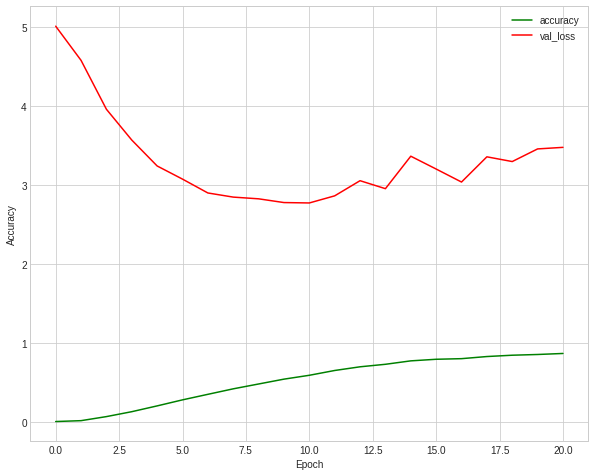

In [74]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,8))

plt.plot(results.history["accuracy"],label='accuracy',color='green')
plt.plot(results.history["val_loss"],label='val_loss',color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

In [75]:
model.predict(X_test[0:1])

array([[7.34249195e-09, 1.04367130e-01, 5.20356116e-06, 1.78654734e-02,
        2.73428753e-07, 1.91626413e-07, 9.50380345e-05, 2.95996889e-02,
        1.70617513e-11, 3.20495275e-08, 6.67336906e-07, 7.54089235e-10,
        2.75218365e-04, 1.09874318e-05, 4.48096715e-09, 4.17192632e-06,
        3.85418764e-09, 9.94937960e-03, 9.58574004e-04, 1.31272045e-05,
        2.48989540e-08, 9.38976186e-08, 8.39914719e-07, 4.60042283e-02,
        1.67539991e-08, 3.13087329e-02, 1.37641530e-06, 8.95850942e-04,
        4.23326152e-10, 5.42384051e-02, 1.32875300e-07, 1.46700330e-09,
        9.83006210e-09, 1.18044272e-06, 1.40089995e-10, 1.49015443e-06,
        3.59256865e-06, 2.47980293e-04, 5.58617685e-05, 3.66695407e-09,
        5.86494291e-03, 6.48748577e-02, 4.46823833e-05, 1.76341028e-03,
        5.75414845e-07, 3.64878029e-01, 9.98159430e-06, 3.76537850e-04,
        6.52936160e-06, 4.73543923e-06, 3.84067302e-03, 3.45070352e-04,
        1.47022658e-10, 8.19476281e-06, 1.20377028e-03, 1.394095

In [76]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

47/47 - 11s - loss: 3.4762 - accuracy: 0.4294 - 11s/epoch - 234ms/step


In [77]:
!ls 

drive  FMbest.hdf5  sample_data


In [78]:
model.load_weights(checkpoint_filepath)

In [79]:
model.predict(X_test[0:1])

array([[6.18337594e-08, 6.26442879e-02, 7.45822399e-05, 1.46848867e-02,
        2.05138235e-06, 3.08345102e-06, 3.68275389e-04, 1.69720352e-02,
        2.18734059e-10, 1.01511617e-07, 4.45596652e-06, 4.88731260e-08,
        1.73588935e-03, 1.14648486e-04, 5.38811396e-09, 6.88355867e-05,
        7.10169612e-09, 3.03740911e-02, 1.93567406e-02, 1.72624408e-04,
        3.17044487e-06, 7.82814652e-07, 7.60335524e-06, 1.33845553e-01,
        1.16438038e-07, 6.74154311e-02, 1.35569026e-05, 6.90553989e-03,
        4.33767866e-09, 7.99416304e-02, 8.03323701e-07, 2.18167227e-08,
        1.42806357e-07, 2.67114865e-05, 1.37866851e-09, 2.77258368e-06,
        1.20195793e-04, 5.10938524e-04, 1.50202904e-04, 3.51160203e-08,
        3.04203550e-03, 2.53171809e-02, 1.73036955e-04, 2.29914524e-02,
        7.59335535e-06, 1.12503201e-01, 4.11463334e-05, 4.07989090e-03,
        7.11273460e-05, 5.84122863e-05, 5.57248807e-03, 1.91216078e-03,
        6.26783425e-09, 7.37258088e-05, 2.41263187e-03, 2.156551

In [80]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

47/47 [==============================] - 11s 233ms/step - loss: 2.7727 - accuracy: 0.4048


In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

NameError: ignored